# SITE: IMAGE PROCESSING AND FEATURE EXTRACTION

Note: The documentation is aimed to be able to perform the SITE computational pipeline from start to end with generation of certain types of graphs. Each part can be separated out and requires changing of kernels with different packages. 

## Table of Contents
- [Section 1 – Region of interest (ROI) extraction ](#s1)
- [Section 2 – Generation of training dataset for cellular segmentation ](#s2)
- [Section 3 – Generation of training dataset for ilastik microenvironment segmentation](#s3)
- [Section 4 – Creating segmentation masks for cellpose and ilastik](#s4)
- [Section 5 – Cellular segmentation](#s5)
- [Section 6 – Microenvironment segmentation](#s6)
- [Section 7 – Featurization and tracking](#s7)


We will start by establishing the data information, paths and other parameters that will be used in each step of the SITE pipeline. Initialize this section at the start of each kernel switch. 

For this documentation, we will be analyzing a subset of the data from both the mammaSITE and lungSITE models. PART I involves extraction of small subvolumes for easier handling and data management. ROI extraction produces TIF files that will be used in future steps. These TIF files are saved to the working directory.


*Obtained from NIS-Elements AR*
| Properties              | Organoid                                      | Lung                                            |
|----------               |----------                                     |----------                                       |
| **Filename**            | Organoid_documentation.nd2                    | Lung_documentation.nd2                          | 
| **File Type**           | ND2 document                                  | ND2 document                                    |
| **Calibration**         | 0.33microns/px                                | 0.33microns/px                                  |
| **Optics**              | Apo LWD 40X Water Immersion                   | Apo LWD 40X Water Immersion                     |
| **Dimensions**          | Time(73) x XY(4) x Channels(3) x Z(26)        | Time(73) x XY(4) x Channels(3) x Z(26)          |
| **Numerical Aperture**  | 1.15                                          | 1.15                                            |
| **Refractive Index**    | 1.33                                          | 1.33                                            |
| **Channel Names**       | CY5 (nuclei),YFP (Reporter),BF (Bright Field) | DAPI (nuclei),YFP (Reporter),BF (Bright Field)  |


In [ ]:
import os
import numpy as np

imagefilename='Organoid_documentation.nd2'
datapath = '/mnt/d/vaibhav/Documentation'
imagefile = os.path.join(datapath, imagefilename)

micron_per_pixel=.33       #lateral resolution (image pixel size)
micron_per_z=3.0           #axial resolution between z-slices
nucl=40                    #typical nucleus linear diameter pixels
zscale=micron_per_z/micron_per_pixel

#Naming convention: All files will be designated by this name. 
modelName = f'20251015_Organoid_Documentation'

channels = ['CY5','YFP','BF']
channel_dict=dict([(x, i) for i, x in enumerate(channels)])

nuc_channel=0 #nuclear channel
rep_channel=1 #reporter channel (ERK here)
bf_channel=2  #bright-field channel


nxy=23
ind_xy = np.arange(nxy).astype(int) #if restarting script, add this to establish wells

nt=73 

## Section 1: Region of interest (ROI) extraction

#### Step 1: Load Libraries

**Note: Kernel being used here is celltraj_env**

In [ ]:
%%capture
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import convenience_features as cf
import importlib
importlib.reload(cf)
import imageprep as imprep
import utilities
import skimage.filters
import scipy.ndimage
from skimage.filters import threshold_local
from skimage.segmentation import clear_border
import cmapfile
import pathlib
import nd2
from skimage.measure import regionprops_table
from IPython.display import clear_output
import os, glob, shutil, re, math
from collections import defaultdict
from PIL import Image

#### Step 2: Load imaging files and imaging parameters

Here, we load up the ND2 files. These files come with an awkard order and requires rearranging for downstream processing.  
The order of a standard live-cell imaging of ND2 file: *Time x XY x Z x Channels x X_Pixles x Y_Pixels* and we require it to be *XY x Time x Z x X_Pixels x Y_Pixels x Channels*  
Of note, here, nuclear staining is performed using a Cy5 dye (as opposed to Hoechst/DAPI) and must be accordingly adjusted.

In [ ]:
imgs = nd2.imread(imagefile,dask=True)
print('Initial ND2 file shape (Time, nXY, nZ, nChannel, nPixels-X, nPixels-Y):', imgs.shape)

imgs=np.swapaxes(imgs,3,5) #nd2 comes with an awkward channel order, rearranging
imgs=np.swapaxes(imgs,0,1)
nxy,nt,nz,nx,ny,nchannel=imgs.shape
ind_xy = np.arange(nxy).astype(int) 

print('New ND2 file shape (nXY, Time, nZ, nPixels-X, nPixels-Y, nChannel):', imgs.shape)
print('Number of XY:', nxy)
print('Number of timepoints:', nt)
print('Number of Z-slices:', nz)
print('Number of channels:', nchannel)

---
Example Output for Organoid dataset-  
Initial ND2 file shape (Time, nXY, nZ, nChannel, nPixels-X, nPixels-Y: (73, 4, 26, 3, 1152, 1152)  
New ND2 file shape (nXY, Time, nZ, nPixels-X, nPixels-Y, nChannel): (4, 73, 26, 1152, 1152, 3)  
Number of XY: 4  
Number of timepoints: 73  
Number of Z-slices: 26  
Number of channels: 3  

#### Step 3: ROI extraction

We are going to extract cell-containing regions from the images using the bright-field channel. It is critical to examine the effectiveness of these foreground/background masks, and if necessary adjust parameters or try another method to get them accurate.  

These parameters can be adjusted to create coarse segmentation masks--  
**zcut-** cut off parameter for setting foreground mask. Number of standard deviations above background  
**scut-** cut off parameter for reporter signal. Number of standard deviations above background

Here, we use the nuclear diameter (nucl) defined earlier to use for bounding dimensions, but can be adjusted accordingly. 

In [ ]:
zcut = 2.0 
scut = 5.0 
rsmooth = nucl                        #smoothing size for foreground mask
sizecut = nucl*nucl*nucl/zscale       #minimum size of region to keep as ROI
borders = [2,4*nucl,4*nucl]           #extension beyond foreground masks to keep in saved ROI
save_bf_labels = False                #True- save foreground masks as their own file
nt_test=5;                            #number of times to check foreground mask to obtain overall bounding box
test_times=np.linspace(0,nt-1,nt_test).astype(int)
visual = True 
if test_times[-1]<nt-1:
    test_times=np.append(test_times,np.array([nt-1]).astype(int))

Extraction of ROIs involve 4 basic steps: 
1. Preliminary removal of outlier signal and gaussian smoothing of reporter channel (YFP).
2. Thresholding of guassian smoothed reporter channel using z-score (zcut) and removal of dim nuclei(intensity_max<mean+scut) or small objects (featSize<sizecut)
3. Remove dim reporter channel objects.
4. Extract ROIs along with their location coordinates within the image field.

This section produces three types of files:  
a. .tif files of extracted ROIs  
b. _max.png files for visualization of extracted ROIs  
c. ROI.npy files that contain the ROI coordinates.

In [ ]:
# Clear the previous plots and open a single figure for live preview.
if visual:
    plt.close('all')
    fig = plt.figure(figsize=(10, 10))

for ixy in ind_xy:
    labels_roi = np.zeros((nt_test, nz, nx, ny), dtype=np.uint8)
    figid = f'{modelName}_XY{ixy}'

    for itt in range(nt_test):
        iS = test_times[itt]
        print(f'Loading frame {iS} XY{ixy}...')

        img = imgs[ixy, iS, ...].compute()  # (Z, X, Y, C)
        img_nuc = imprep.histogram_stretch(img[:, :, :, nuc_channel])
        img_nuc[img_nuc > 50 * np.std(img_nuc)] = 0
        img_fl = img[:, :, :, rep_channel]
        img_fl_smth = skimage.filters.gaussian(
            img_fl,
            sigma=[rsmooth / zscale, rsmooth, rsmooth],
            mode='wrap'
        )

        # Initial Segmentation (foreground) + Nuclear Filter
        # -------------------------------------------------------------------------------------------------------------------------------------------------------
        msk_fl = imprep.znorm(img_fl_smth) > zcut
        label = imprep.get_labeled_mask(msk_fl)

        mu_n, sd_n = np.mean(img_nuc), np.std(img_nuc)
        props = regionprops_table(
            label,
            intensity_image=img_nuc,
            properties=('label', 'intensity_max'),
            extra_properties=(cf.featSize, cf.meanIntensity, cf.totalIntensity)
        )
        ind_empty = props['label'][props['intensity_max'] < (mu_n + scut * sd_n)]
        ind_small = props['label'][props['featSize'] < sizecut]
        rm = np.union1d(ind_empty, np.setdiff1d(ind_small, ind_empty))
        if rm.size:
            label[np.isin(label, rm)] = 0

        # Second Round (reporter refinement)
        # -------------------------------------------------------------------------------------------------------------------------------------------------------
        label2 = imprep.get_labeled_mask(label > 0)
        mu_f, sd_f = np.mean(img_fl), np.std(img_fl)
        props2 = regionprops_table(
            label2,
            intensity_image=img_fl,
            properties=('label', 'intensity_max'),
            extra_properties=(cf.featSize, cf.meanIntensity, cf.totalIntensity)
        )
        ind_empty2 = props2['label'][props2['intensity_max'] < (mu_f + scut * sd_f)]

        if ind_empty2.size:
            label2[np.isin(label2, ind_empty2)] = 0

        label3 = imprep.get_labeled_mask(label2 > 0)
        labels_roi[itt, ...] = label3

        # Per-frame XY, XZ and YZ Visualization
        # -------------------------------------------------------------------------------------------------------------------------------------------------------
        if visual and label3.any():
            props3 = regionprops_table(
                label3,
                intensity_image=img_fl,
                properties=('label', 'centroid'),
                extra_properties=(cf.featSize, cf.meanIntensity, cf.totalIntensity)
            )

            clear_output(wait=True)
            plt.clf()
            ax_xy, ax_xz, ax_yz = cf.show_3dseg_zproj(
                fig,
                np.abs(imprep.znorm(img_fl)),  # (Z, X, Y) intensity
                label3,                        # (Z, X, Y) labels
                fmap=imprep.get_feature_map(props3['meanIntensity'], label3),
                zscale=zscale,
                title=f'frame {iS}'
            )

            # True boundary overlays (preserve limits)
            axes = (ax_xy, ax_xz, ax_yz)
            masks = (
                ((np.max(label3, axis=0) > 0).T, (0, label3.shape[2], 0, label3.shape[1])),
                ((np.max(label3, axis=2) > 0).T, (0, label3.shape[0] * zscale, 0, label3.shape[1])),
                ((np.max(label3, axis=1) > 0).T, (0, label3.shape[0] * zscale, 0, label3.shape[2])),
            )
            for ax, (M, ext) in zip(axes, masks):
                xlim, ylim = ax.get_xlim(), ax.get_ylim()
                ax.contour(M, levels=[0.5], colors='blue', linewidths=1,
                           origin='lower', extent=ext)
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)

            # Voxel-count text on XY
            for i in range(props3['label'].size):
                ax_xy.text(
                    props3['centroid-1'][i],
                    props3['centroid-2'][i],
                    f"{props3['featSize'][i]:.2e} vox",
                    color='black', fontsize=8
                )
            plt.pause(0.1)

    labels_3d = np.max(labels_roi > 0, axis=0).astype(int)
    scipy.ndimage.label(labels_3d, output=labels_3d)

    # Save 3-D Label Mask & Quick Visual
    # -------------------------------------------------------------------------------------------------------------------------------------------------------
    if save_bf_labels:
        skimage.io.imsave(f'labels_{figid}.tif', labels_3d)

    labels_roi = np.max(labels_3d, axis=0).astype(int)
    if visual:
        clear_output(wait=True)
        plt.clf()
        plt.contour(labels_roi.T, levels=np.unique(labels_roi), cmap=plt.cm.viridis)
        xt = imprep.get_cell_centers(labels_3d)
        print(xt)
        for icenter in range(xt.shape[0]):
            if not np.isnan(np.sum(xt[icenter])):
                indcenter = xt[icenter, :].astype(int)
                ilabel = labels_3d[indcenter[0], indcenter[1], indcenter[2]]
                plt.text(xt[icenter, 1], xt[icenter, 2], str(ilabel), color='red')
        plt.pause(0.1)

    # Extract ROIs & Save T-series BigTIFFs
    # -------------------------------------------------------------------------------------------------------------------------------------------------------
    props_rois = regionprops_table(labels_3d, properties=('label', 'area', 'bbox'))
    ind_rois = np.where(props_rois['area'] > (nucl ** 3) / zscale)[0]

    for i_roi in range(ind_rois.size):
        z0 = max(0, props_rois['bbox-0'][ind_rois[i_roi]] - borders[0])
        z1 = min(nz, props_rois['bbox-3'][ind_rois[i_roi]] + borders[0])
        x0 = max(0, props_rois['bbox-1'][ind_rois[i_roi]] - borders[1])
        x1 = min(nx, props_rois['bbox-4'][ind_rois[i_roi]] + borders[1])
        y0 = max(0, props_rois['bbox-2'][ind_rois[i_roi]] - borders[2])
        y1 = min(ny, props_rois['bbox-5'][ind_rois[i_roi]] + borders[2])

        img_roi = imgs[ixy, :, z0:z1, x0:x1, y0:y1, :].compute()
        fname = f'{figid}_roi{i_roi}.tif'
        skimage.io.imsave(fname, img_roi, bigtiff=True)

        roi_coords = np.zeros((3, 2), dtype=int)
        roi_coords[0, 0] = z1
        roi_coords[0, 1] = z0
        roi_coords[1, 0] = x1
        roi_coords[1, 1] = x0
        roi_coords[2, 0] = y1
        roi_coords[2, 1] = y0
        np.save(f'roicoords_{figid}_roi{i_roi}.npy', roi_coords)

        # ROI Max-projection QC Snapshot
        # -------------------------------------------------------------------------------------------------------------------------------------------------------
        if visual:
            try:
                clear_output(wait=True)
                plt.clf()
                plt.imshow(imprep.znorm(np.max(img_roi[..., bf_channel], axis=(0, 1))).T,
                           cmap=plt.cm.binary, clim=(-5, 5))
                cs = plt.contour(
                    imprep.znorm(np.max(img_roi[..., nuc_channel], axis=(0, 1))).T,
                    cmap=plt.cm.BuPu,
                    levels=np.linspace(1, np.percentile(imprep.znorm(img_roi[..., nuc_channel]), 99), 7),
                    alpha=0.3)
                cs.cmap.set_over('purple')

                cs = plt.contour(
                    imprep.znorm(np.max(img_roi[..., rep_channel], axis=(0, 1))).T,
                    cmap=plt.cm.YlOrBr_r,
                    levels=np.linspace(1, np.percentile(imprep.znorm(img_roi[..., rep_channel]), 99), 7),
                    alpha=0.7)
                cs.cmap.set_over('yellow')

                plt.contour(np.max(labels_3d[z0:z1, x0:x1, y0:y1], axis=0).T,
                            levels=[0, 1], colors='black')
                plt.axis('equal')
                plt.axis('off')
                plt.savefig(f'{figid}_roi{i_roi}_maxp.png')
                plt.pause(0.1)
            except Exception as e:
                print(e)


**Where are the generated files located and stored?**    
The generated .tif files are stored in the working directory from where the jupyter notebook is launched. To change the directory, adjust the save path in the script above.

Extract ROIs can extract multiple ROIs per XY depending on the cell density. Once the .tif files are generated, the original ND2 file can be deleted or moved and will no longer be used for the rest of the analysis.

Example max png file:  
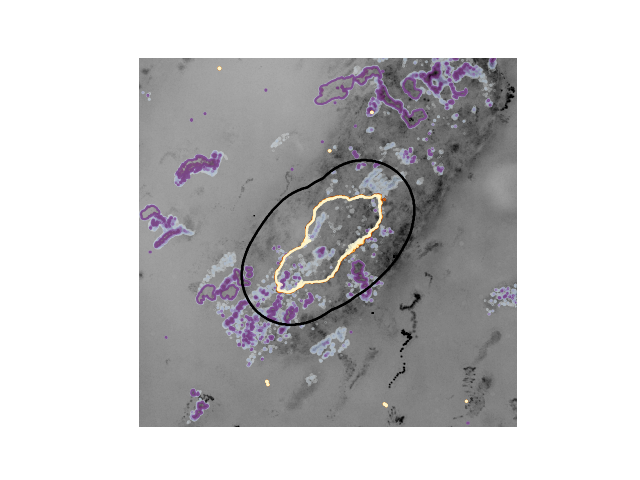  


Once the ROIs have been generated, improper ROIs can be selected and stored away to avoid processing further downstream steps. 

In [ ]:
output_dir = os.path.join(datapath, 'unselected_rois')
os.makedirs(output_dir, exist_ok=True)

# 1) Re-scan the .pngs and re-build xy_groups
png_files = sorted(glob.glob(os.path.join(datapath, '*_XY*_roi*_*.png')))
xy_groups = defaultdict(list)
for png in png_files:
    fn   = os.path.basename(png).split('_')
    xy   = next((p for p in fn if p.startswith('XY')), None)
    roi  = next((p for p in fn if p.startswith('roi')), None)
    if xy and roi:
        xy_groups[xy].append((png, roi))
        
        quit_all = False
xy_keys = sorted(xy_groups, key=cf.xy_sort_key)

for xy in xy_keys:
    if quit_all:
        break
    selected = set()
    rejected = set()

    print(f"\nStarting {xy} (total {len(xy_groups[xy])} ROIs)")
    for png, roi in xy_groups[xy]:
        action = cf.prompt_roi(png, xy, roi, selected, rejected, xy_groups)
        if action == 'q':
            quit_all = True
            break
        if action == 's':
            print(f"⏭ Skipping rest of {xy}")
            break
        uid = (xy, roi)
        if action == 'y':
            selected.add(uid)
        else:
            rejected.add(uid)

    # final summary & move rejects
    clear_output(wait=True)
    cf.display_thumbnails(xy, selected, rejected, xy_groups)
    moved = 0
    for png, roi in xy_groups[xy]:
        uid = (xy, roi)
        if uid in rejected:
            # move the PNG
            shutil.move(png, os.path.join(output_dir, os.path.basename(png)))
            # move ALL matching TIFFs
            for tif in cf.get_tifs_for_png(png):
                shutil.move(tif, os.path.join(output_dir, os.path.basename(tif)))
            moved += 1
    print(f"Finished {xy}: moved {moved} to '{output_dir}'")

print("Done.")  

## Section 2: Generation of training dataset for cellular segmentation

To obtain singel-cell cytoplasmic and nuclear masks, we will utilize a deep learning-based approach using cellpose3. To create a model that can accurately segment cells, we must first generate a random representative subset of training images. These representative 2-D slices will be generated from three channel (Brightfield, fluorescent reporter and nuclear) 4-D stacks with varying intensity to capture the variations in the dataset.


**Note: This step can be run directly after generation of ROIs without the need to switch kernels.**  

Now, we have set up a new folder to store the images that we will generate and use to train our segmentation model.  
We can use the same training images to create both nuclear and cytoplasmic models, however, masks will need to be created separately. We just create a duplicate of the images generated in this segment. 

In [ ]:
%%capture
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import convenience_features as cf
import importlib
importlib.reload(cf)
import imageprep as imprep
import utilities
import skimage.filters
import scipy.ndimage
from skimage.filters import threshold_local
from skimage.segmentation import clear_border
import cmapfile
import pathlib
import nd2
from skimage.measure import regionprops_table
from IPython.display import clear_output
import os

In [ ]:
date = '20251021'                                                #Date of generation of training data
purpose= 'Cellpose_cytotraining_organoid'                        #Training data for cellpose (Cellpose_segmentation) or iLASTIK
trainpath = f'{datapath}/{date}_{purpose}'     #Path where training data will be saved

pathexists = os.path.isdir(trainpath)                            #create training folder if it doesn't exist already
if not pathexists:
    os.mkdir(trainpath)

In this section, we define the number and type of training images we are interested in generating.  

The following parameters can be changed to get desired training data--  
**nz_random-** random z-slice to seed for nz-contiguous. eg. nz_random=3 would produce 3 seeding z slices from which contiguous images will be produced.   
**nz_contiguous-** number of z-frames that are continous. eg. nz_contiguous=5 would produce 5 contiguous z-images for each nz_random.   
**nlateral_random-** random number of lateral segmentation training images to produce  
**nt_train-** number of time frames to generate training images  
**itrain-** starting time indices for training images  

A key strength of SITE, is the ability to perform segmentation in 3D using lateral training and segmentation. Segmentation and training of lateral slices is crucial for accurate 3D segmentation. For 2D data, nlateral_random can be skipped. 

In [ ]:
visual=True                            

nz_random=2                             
nz_contiguous=2                       
nlateral_random=2                       
nt_train=2                              
itrain=2

train_frames=np.linspace(itrain,nt-1,nt_train).astype(int)
print('Time point frames chosen for training', train_frames)

int_cut=1.2 
highlow_perc=.1
int_scale=.1                            #scaling between brightfield in fluorescence

combine_nuc_channels=False              #if using 2 nuclear reporters, set to TRUE.
nuc_channel2=1                          #Assign second nuclear channel index

In [ ]:
for ixy in ind_xy:
    imagelist = imprep.list_images(f'{datapath}/{modelName}_XY{ixy}_roi*.tif') #get list of all ROI images per XY
    n_rois=len(imagelist)

    for i_roi in range(n_rois):
        imgs_roi=skimage.io.imread(imagelist[i_roi])
        nt_roi,nz_roi,nx_roi,ny_roi,nchannels_roi=imgs_roi.shape
        train_frames=np.linspace(0,nt_roi-1,nt_train).astype(int)

        for itt in range(0,nt_train):
            iS=train_frames[itt]
            img=imgs_roi[iS,...].astype(float)
            int_low=np.percentile(img,highlow_perc,axis=(0,1,2))
            int_high=np.percentile(img,100.-highlow_perc,axis=(0,1,2))
            int_ratio=np.divide(int_high,int_low) #estimate of the intensity variation in the channel
            im3d_nuc=cf.rescale_to_int(imprep.znorm(img[...,nuc_channel]))
            
            if combine_nuc_channels:
                nuc_dtype=im3d_nuc.dtype
                im3d_nuc2=cf.rescale_to_int(imprep.znorm(img[...,nuc_channel2]))
                im3d_nuc=.5*im3d_nuc2+.5*im3d_nuc
                im3d_nuc=im3d_nuc.astype(nuc_dtype)
            im3d_rep=cf.rescale_to_int(imprep.znorm(img[...,rep_channel]))
            im3d_bf=imprep.znorm(img[...,bf_channel])
            im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
            im3d_bf=cf.rescale_to_int(im3d_bf)
            cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
            cellpose_img[:,0,:,:]=im3d_bf #.5*(im3d_rep+im3d_nuc) #add in nuc so not hollow
            cellpose_img[:,1,:,:]=im3d_rep
            cellpose_img[:,2,:,:]=im3d_nuc
           
            try:
                if (int_ratio<int_cut).any(): #extract slices from rois with meaningful intensity variation
                    raise Exception(f"Intensity high/low percentile ratios {int_ratio[0]:.2f},{int_ratio[1]:.2f},{int_ratio[2]:.2f} less than specified cutoff {int_cut}: xy{ixy} roi{i_roi} t{iS}")
                    if visual:
                        clear_output(wait=True);plt.clf();plt.imshow(np.max(cellpose_img[:,0,:,:],axis=0));plt.pause(.5);
                indsz=np.argsort(np.mean(im3d_nuc,axis=(1,2)))[-2*nz_random:]               #np.where(np.mean(im3d_nuc,axis=(1,2))>np.mean(im3d_nuc)+.1*np.std(im3d_nuc))[0]
                z_inds=np.random.choice(indsz,size=nz_random,replace=False).astype(int)
                indsx=np.argsort(np.mean(im3d_nuc,axis=(0,2)))[-2*nlateral_random:]         #np.where(np.mean(im3d_nuc,axis=(0,2))>np.mean(im3d_nuc)+.1*np.std(im3d_nuc))[0]
                x_inds=np.random.choice(indsx,size=nlateral_random,replace=False).astype(int)
                indsy=np.argsort(np.mean(im3d_nuc,axis=(0,1)))[-2*nz_random:]               #np.where(np.mean(im3d_nuc,axis=(0,1))>np.mean(im3d_nuc)+.1.*np.std(im3d_nuc))[0]
                y_inds=np.random.choice(indsy,size=nlateral_random,replace=False).astype(int)
                ix=np.argsort(np.sum(np.sum(im3d_nuc,axis=2),axis=0))[-1]
                iy=np.argsort(np.sum(np.sum(im3d_nuc,axis=1),axis=0))[-1]
                imgsz=[None]*nz_random
                for iz in range(nz_random):
                    zrange=np.arange(z_inds[iz]-nz_contiguous,z_inds[iz]+nz_contiguous+1)
                    zrange=zrange[zrange>=0];zrange=zrange[zrange<nz_roi]
                    imgsz[iz]=cellpose_img[z_inds[iz],:,:,:]
                    for izc in zrange:
                        imgz=cellpose_img[izc,:,:,:]
                        fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_z{z_inds[iz]+1}_xy{ixy+1}_roi{i_roi}.tif'
                        skimage.io.imsave(fname,imgz.T)
                        itrain=itrain+1
                for ilat in range(nlateral_random):
                    ix=x_inds[ilat]
                    iy=y_inds[ilat]
                    imgy=cellpose_img[:,:,:,iy]
                    imgy=skimage.transform.rescale(imgy,(zscale,1,1),anti_aliasing=False)
                    imgy=np.swapaxes(imgy,1,0)
                    fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_y{iy+1}_xy{ixy+1}_roi{i_roi}.tif'
                    skimage.io.imsave(fname,imgy.T)
                    itrain=itrain+1
                    imgx=cellpose_img[:,:,ix,:]
                    imgx=skimage.transform.rescale(imgx,(zscale,1,1),anti_aliasing=False)
                    imgx=np.swapaxes(imgx,1,0)
                    fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_x{ix+1}_xy{ixy+1}_roi{i_roi}.tif'
                    skimage.io.imsave(fname,imgx.T)
                    itrain=itrain+1
                    if visual:
                        clear_output(wait=True);plt.clf()
                        for iz in range(nz_random):
                            plt.subplot(1,3,1)
                            cf.show_image_3channel(imgsz[iz][2,...],imgsz[iz][1,...],imgsz[iz][0,...]);plt.axis('off')
                            plt.subplot(1,3,2)
                            cf.show_image_3channel(imgx[2,...],imgx[1,...],imgx[0,...]);plt.axis('off')
                            plt.subplot(1,3,3)
                            cf.show_image_3channel(imgy[2,...],imgy[1,...],imgy[0,...]);plt.axis('off')
                            plt.pause(.1)
            except Exception as e:
                print(e)

The parameters listed above generate 242 images for model training. A separate training data set must be generated for nuclear segmentation. Note, nuclear segmentation is NOT performed in 3D and lateral training data is not required for it. 

## Section 3: Generation of training dataset for ilastik microenvironment segmentation

To capture spatial context around individual reporter cells within the local tissue microenvironment, we implemented semi-supervised tissue segmentation using the ilastik random-forest classification framework. Documentation on ilastik can be found [here](https://www.ilastik.org/).

We must first generate a separate set of training images, however the process is very similar to generation of a training dataset for the cellpose segmentation and model development. 

In [ ]:
date = '20251016'                                                #Date of generation of training data
purpose= 'ilastik_training_organoid'                             #Training data for cellpose (Cellpose_segmentation) or iLASTIK
trainpath = f'{datapath}/{date}_{purpose}'     #Path where training data will be saved

pathexists = os.path.isdir(trainpath)                            #create training folder if it doesn't exist already
if not pathexists:
    os.mkdir(trainpath)

In this section, we define the number and type of training images we are interested in generating.  

The following parameters can be changed to get desired training data, however for ilastik training, we do not require as many training images. In addition, we do not require lateral segmentation as ilastik segmentation is performed per z-slice--  
**nz_random-** random z-slice to seed for nz-contiguous. eg. nz_random=3 would produce 3 seeding z slices from which contiguous images will be produced.   
**nz_contiguous-** number of z-frames that are continous. eg. nz_contiguous=5 would produce 5 contiguous z-images for each nz_random.   
**nlateral_random-** random number of lateral segmentation training images to produce. For microenvironmental segmentation, this is not required and can be set to 0.  
**nt_train-** number of time frames to generate training images  
**itrain-** starting time indices for training images  

In [ ]:
visual=True                            

nz_random=1                             
nz_contiguous=1                       
nlateral_random=0                       
nt_train=2                              
itrain=2

train_frames=np.linspace(itrain,nt-1,nt_train).astype(int)
print('Time point frames chosen for training', train_frames)

int_cut=1.2 
highlow_perc=.1
int_scale=.1                            #scaling between brightfield in fluorescence

combine_nuc_channels=False              #if using 2 nuclear reporters, set to TRUE.
nuc_channel2=1                          #Assign second nuclear channel index

In [ ]:
for ixy in ind_xy:
    imagelist = imprep.list_images(f'{datapath}/{modelName}_XY{ixy}_roi*.tif') #get list of all ROI images per XY
    n_rois=len(imagelist)

    for i_roi in range(n_rois):
        imgs_roi=skimage.io.imread(imagelist[i_roi])
        nt_roi,nz_roi,nx_roi,ny_roi,nchannels_roi=imgs_roi.shape
        train_frames=np.linspace(0,nt_roi-1,nt_train).astype(int)

        for itt in range(0,nt_train):
            iS=train_frames[itt]
            img=imgs_roi[iS,...].astype(float)
            int_low=np.percentile(img,highlow_perc,axis=(0,1,2))
            int_high=np.percentile(img,100.-highlow_perc,axis=(0,1,2))
            int_ratio=np.divide(int_high,int_low) #estimate of the intensity variation in the channel
            im3d_nuc=cf.rescale_to_int(imprep.znorm(img[...,nuc_channel]))
            
            if combine_nuc_channels:
                nuc_dtype=im3d_nuc.dtype
                im3d_nuc2=cf.rescale_to_int(imprep.znorm(img[...,nuc_channel2]))
                im3d_nuc=.5*im3d_nuc2+.5*im3d_nuc
                im3d_nuc=im3d_nuc.astype(nuc_dtype)
            im3d_rep=cf.rescale_to_int(imprep.znorm(img[...,rep_channel]))
            im3d_bf=imprep.znorm(img[...,bf_channel])
            im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
            im3d_bf=cf.rescale_to_int(im3d_bf)
            cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
            cellpose_img[:,0,:,:]=im3d_bf #.5*(im3d_rep+im3d_nuc) #add in nuc so not hollow
            cellpose_img[:,1,:,:]=im3d_rep
            cellpose_img[:,2,:,:]=im3d_nuc
           
            try:
                if (int_ratio<int_cut).any(): #extract slices from rois with meaningful intensity variation
                    raise Exception(f"Intensity high/low percentile ratios {int_ratio[0]:.2f},{int_ratio[1]:.2f},{int_ratio[2]:.2f} less than specified cutoff {int_cut}: xy{ixy} roi{i_roi} t{iS}")
                    if visual:
                        clear_output(wait=True);plt.clf();plt.imshow(np.max(cellpose_img[:,0,:,:],axis=0));plt.pause(.5);
                indsz=np.argsort(np.mean(im3d_nuc,axis=(1,2)))[-2*nz_random:]               #np.where(np.mean(im3d_nuc,axis=(1,2))>np.mean(im3d_nuc)+.1*np.std(im3d_nuc))[0]
                z_inds=np.random.choice(indsz,size=nz_random,replace=False).astype(int)
                indsx=np.argsort(np.mean(im3d_nuc,axis=(0,2)))[-2*nlateral_random:]         #np.where(np.mean(im3d_nuc,axis=(0,2))>np.mean(im3d_nuc)+.1*np.std(im3d_nuc))[0]
                x_inds=np.random.choice(indsx,size=nlateral_random,replace=False).astype(int)
                indsy=np.argsort(np.mean(im3d_nuc,axis=(0,1)))[-2*nz_random:]               #np.where(np.mean(im3d_nuc,axis=(0,1))>np.mean(im3d_nuc)+.1.*np.std(im3d_nuc))[0]
                y_inds=np.random.choice(indsy,size=nlateral_random,replace=False).astype(int)
                ix=np.argsort(np.sum(np.sum(im3d_nuc,axis=2),axis=0))[-1]
                iy=np.argsort(np.sum(np.sum(im3d_nuc,axis=1),axis=0))[-1]
                imgsz=[None]*nz_random
                for iz in range(nz_random):
                    zrange=np.arange(z_inds[iz]-nz_contiguous,z_inds[iz]+nz_contiguous+1)
                    zrange=zrange[zrange>=0];zrange=zrange[zrange<nz_roi]
                    imgsz[iz]=cellpose_img[z_inds[iz],:,:,:]
                    for izc in zrange:
                        imgz=cellpose_img[izc,:,:,:]
                        fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_z{z_inds[iz]+1}_xy{ixy+1}_roi{i_roi}.tif'
                        skimage.io.imsave(fname,imgz.T)
                        itrain=itrain+1
                for ilat in range(nlateral_random):
                    ix=x_inds[ilat]
                    iy=y_inds[ilat]
                    imgy=cellpose_img[:,:,:,iy]
                    imgy=skimage.transform.rescale(imgy,(zscale,1,1),anti_aliasing=False)
                    imgy=np.swapaxes(imgy,1,0)
                    fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_y{iy+1}_xy{ixy+1}_roi{i_roi}.tif'
                    skimage.io.imsave(fname,imgy.T)
                    itrain=itrain+1
                    imgx=cellpose_img[:,:,ix,:]
                    imgx=skimage.transform.rescale(imgx,(zscale,1,1),anti_aliasing=False)
                    imgx=np.swapaxes(imgx,1,0)
                    fname=f'{trainpath}/train{itrain}_{modelName}_t{iS+1}_x{ix+1}_xy{ixy+1}_roi{i_roi}.tif'
                    skimage.io.imsave(fname,imgx.T)
                    itrain=itrain+1
                    if visual:
                        clear_output(wait=True);plt.clf()
                        for iz in range(nz_random):
                            plt.subplot(1,3,1)
                            cf.show_image_3channel(imgsz[iz][2,...],imgsz[iz][1,...],imgsz[iz][0,...]);plt.axis('off')
                            plt.subplot(1,3,2)
                            cf.show_image_3channel(imgx[2,...],imgx[1,...],imgx[0,...]);plt.axis('off')
                            plt.subplot(1,3,3)
                            cf.show_image_3channel(imgy[2,...],imgy[1,...],imgy[0,...]);plt.axis('off')
                            plt.pause(.1)
            except Exception as e:
                print(e)

The parameters listed above generate 58 images for model training. These images will need to be duplicated to create a training dataset for a nuclear model.  

## Section 4: Segmentation masks for Cellpose and ilastik

Training for segmentation masks for Cellpose and ilastik can be performed at the users discretion.  
Below is a representative example of Cellpose annotations that were manually curated for cytoplasmic and nuclear segmentation.  
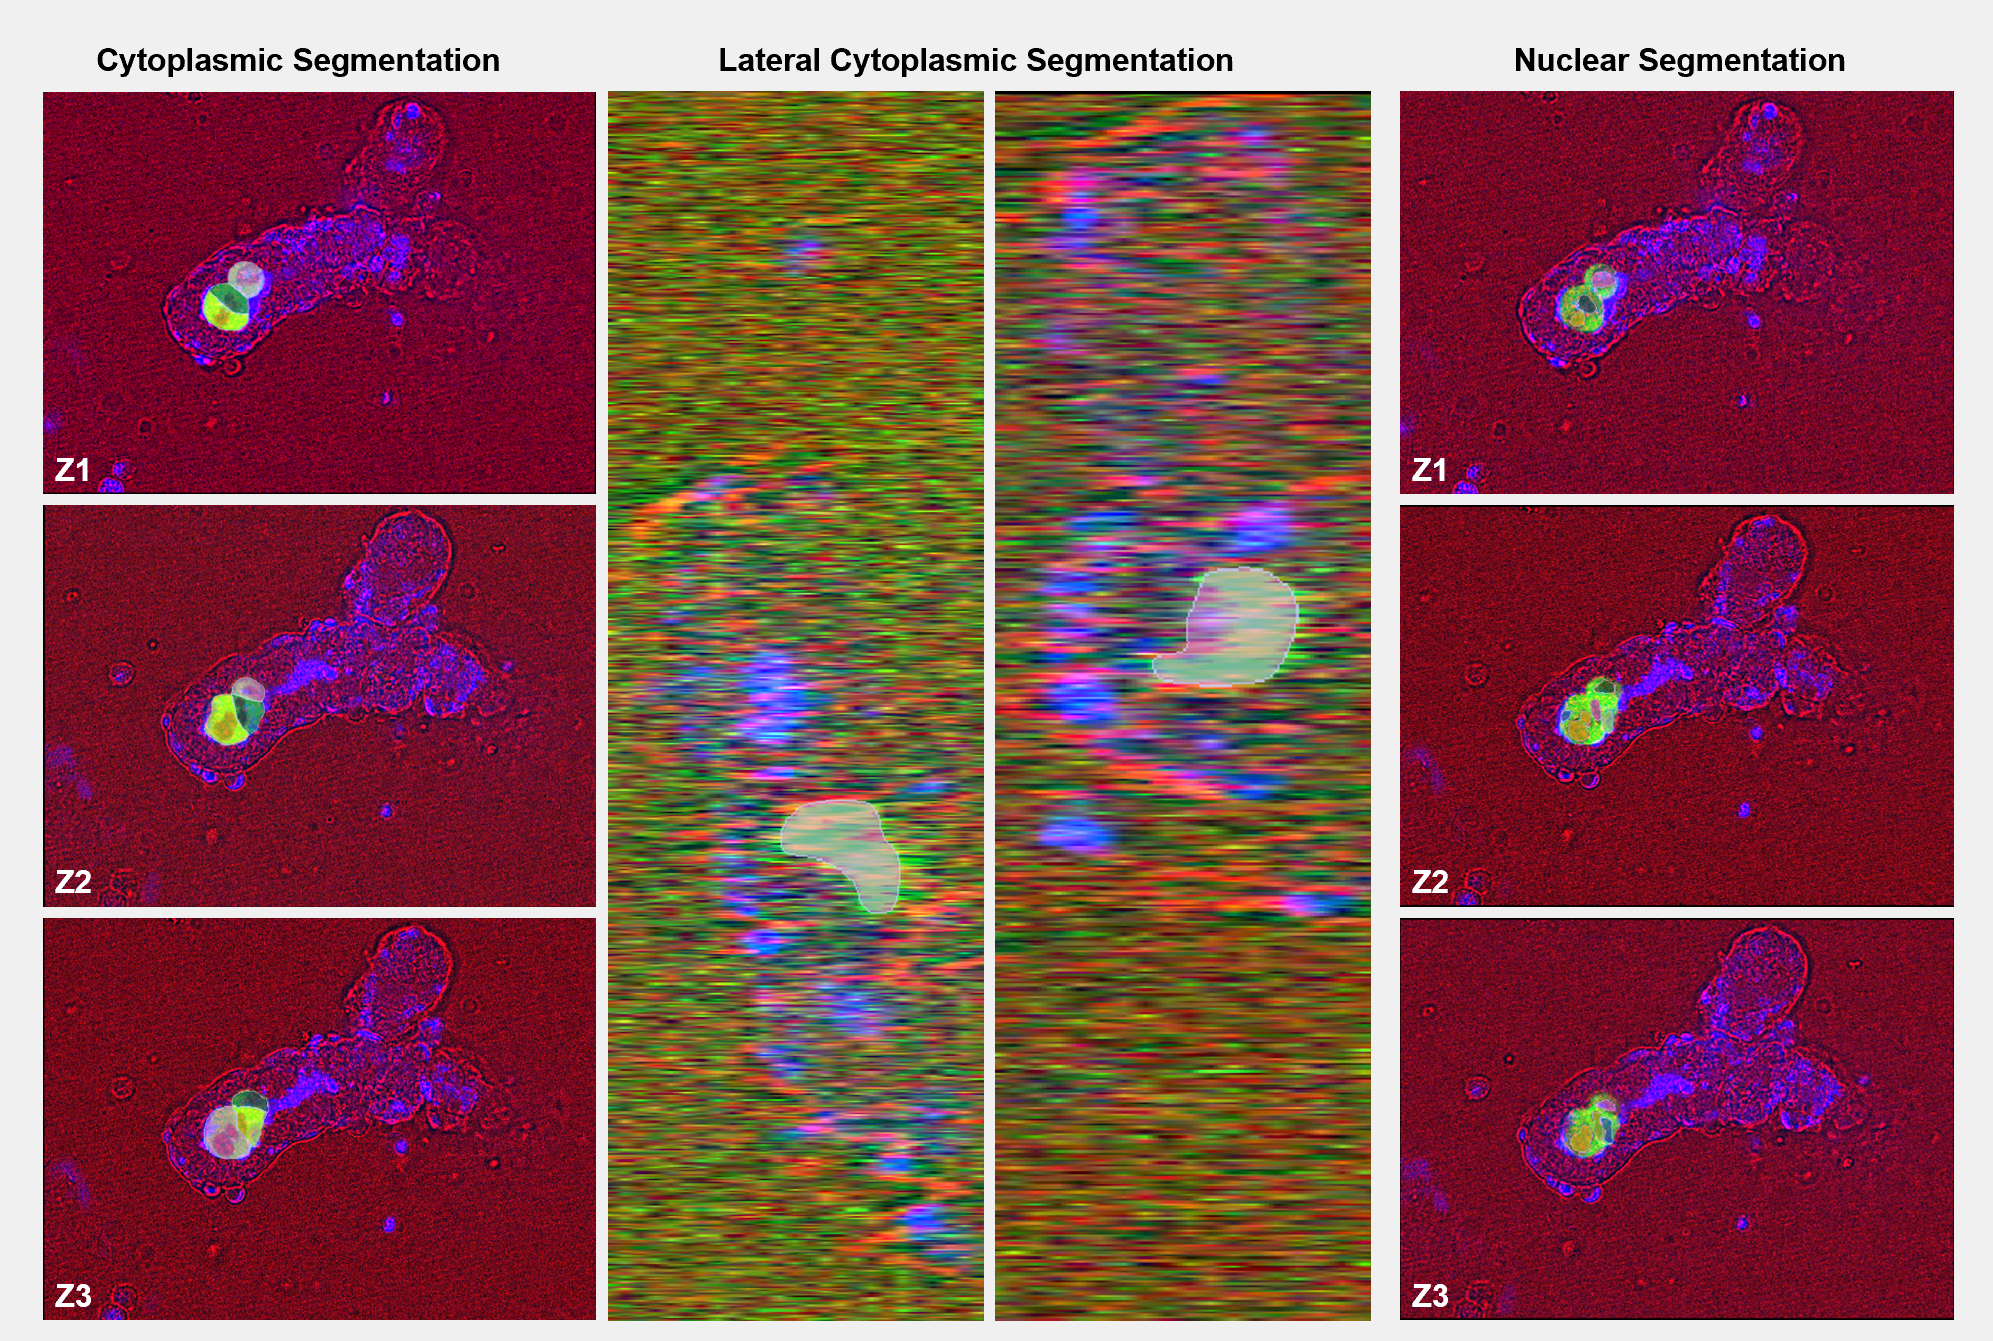

Training for the microenvironment involves manual annotation of pixels into three classes—**primary tissue, extracellular matrix, and reporter cell regions**. We will generate separate ilastik models for the gland and the lung to account for their distinct morphological characteristics.
Below is a representative example of sparse labeling in ilastik
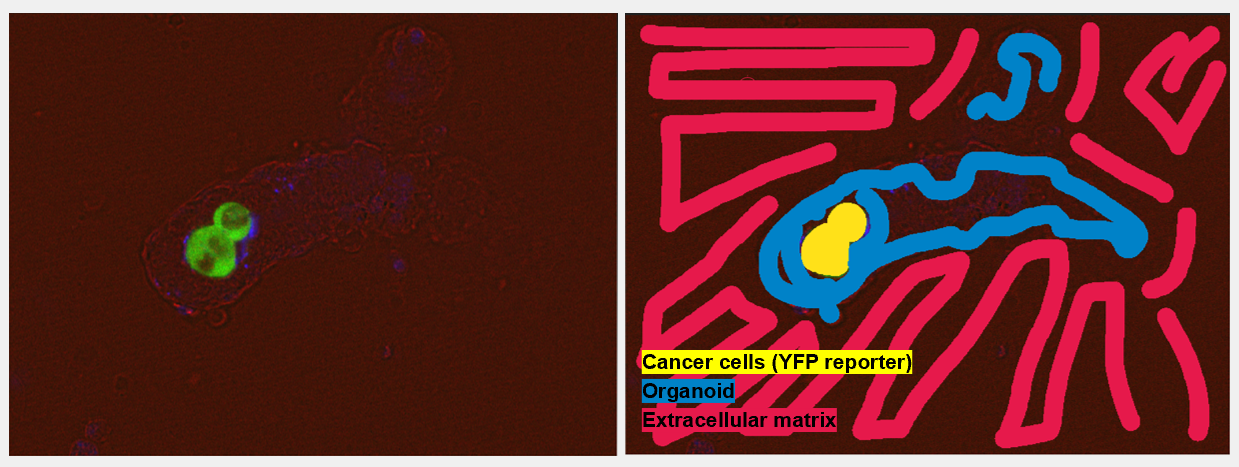

## Section 5: Cellular Segmentation

Following the generation of a segmentation model, individual cells need to be segmented.  

**NOTE: The kernel here must be switched to cellpose_celltraj_env. Since a new kernel is being used, relevant libraries will need to be re-loaded.**  

In [ ]:
#%%capture
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import convenience_features as cf
import imageprep as imprep
import importlib
importlib.reload(cf)
import utilities
import pickle
import tifffile
import skimage.filters
import scipy.ndimage
import csaps
from skimage.filters import threshold_local
from skimage.segmentation import watershed
from skimage.segmentation import clear_border
from skimage.feature import peak_local_max
from skimage import transform as tf
import pyemma.coordinates
from sklearn.mixture import GaussianMixture
from scipy.ndimage import generic_filter
from cellpose import models
import cmapfile
import pathlib
import nd2
from skimage.measure import regionprops_table
from IPython.display import clear_output
import os
ndimage=scipy.ndimage
import re

In [ ]:
combine_nuc_channels = False                               # if using 2 nuclear reporters, set to TRUE.

if not combine_nuc_channels:
    nuc_channel2 = 1

############ END OF SECTION ############

mask_channels=['cyto']                  
fmask_channels=['foreground','nuc']
mskchannel=0
nmaskchannels=len(mask_channels)


Here, we set up the parameters for the segmentation. This script generates reference images of the segmentations as a maximum projection intensity that can be reviewed later or stitched together into a movie to review the segmentation fidelity.  
Once the segmentation is complete, the resulting h5 files can be used for all further analysis.  


The nuclear and cytoplasmic models that we have used for segmentation in this tutorial can be found here.

| Properties              | Organoid                                                 |
|----------               |----------                                                |
|**NUCLEAR MODELS**
| **Model name**          | scratch_Collective_18Nov2024_1000E_green_blue_BEST       |
| **SITE Type**           | Organoid Nuclear                                         |
| **Cellpose Channels**   | 2 (Green),3 (Blue)                                       |
| **Cellpose Diameter**   | 25.84                                                    |
|**Training Epochs**      | 1000                                                     |
|
|**CYTOPLASMIC MODELS**
| **Model name**          | cyto3_Collective_1Nov2024_1000E_green_blue_BEST          |
| **SITE Type**           | Organoid Cytoplasmic                                     |
| **Cellpose Channels**   | 2 (Green), 3 (Blue)                                      |
| **Cellpose Diameter**   | 42.93                                                    |
|**Training Epochs**      | 1000                                                     |


In [ ]:
date = '20251016'                                                           #Date the files are segmented
purpose= 'Cellpose segmentation_organoid'
vizpath=f'{datapath}/{date}_{purpose}'                    #Path where the segmentation images willbe generated

pathexists = os.path.isdir(vizpath)                                         #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
    

# Information for nuclear segmentation
cellpose_modelpath_nuc='/mnt/z/ImagingData/segmentation/collective_nuc/models/scratch_Collective_18Nov2024_1000E_green_blue_BEST'     
model_nuc = models.CellposeModel(gpu=True,pretrained_model=cellpose_modelpath_nuc)
cellpose_channels_nuc = [[2,3]]         #0: None, 1: Red, 2: Green, 3: Blue These are the channels used to make the cellpose model
cellprob_threshold_nuc=0.               #Default is 0. Negative values make the model more permissible 
flow_threshold_nuc=0.4                  #Default = 0.4. Higher values ar more permissible
minsize=int(np.pi*(nucl/2.)**2)         #at least one nuclear slices
maxsize=int(((8*nucl)**3)/zscale);
cellpose_diam_nuc=25.84                  #from mean mask size in training
visual=True; 
live_render=True                        

# Information for cytoplasmic segmentation
cellpose_modelpath='/mnt/z/ImagingData/segmentation/collective_cyto/models/cyto3_Collective_1Nov2024_1000E_green_blue_BEST'
model = models.CellposeModel(gpu=True,pretrained_model=cellpose_modelpath)
cellpose_channels = [[2,3]]             #0: None, 1: Red, 2: Green, 3: Blue These are the channels used to make the cellpose model
cellprob_threshold=0.                   #Default is 0. Negative values make the model more permissible 
flow_threshold=0.4                      #Default = 0.4. Higher values ar more permissible
minsize=int(np.pi*(nucl/2.)**2)         #at least one nuclear slices
maxsize=int(((8*nucl)**3)/zscale)
cellpose_diam=42.93                     #from mean mask size in training
visual=True

rsmooth=nucl/4
rsmooth_nuc=nucl/10
zcut=1.0
zcut_nuc=2.
int_cut=1.05
highlow_perc=.1
nt_train=5; nt
train_frames=np.linspace(0,nt-1,nt_train).astype(int)


In [ ]:
tifs   = cf.get_indices(modelName, f"{datapath}/{modelName}_XY*_roi*.tif", "tif")
coords = cf.get_indices(modelName, f"{datapath}/roicoords_{modelName}_XY*_roi*.npy", "npy")

all_keys = sorted(set(tifs) | set(coords))

for key in all_keys:
    xy, roi = key
    t = tifs.get(key)
    c = coords.get(key)
    if t and c:
        print(f"[OK] XY{xy} roi{roi}: TIFF={t}, COORD={c}")
    elif t and not c:
        print(f"[MISS] XY{xy} roi{roi}: TIFF present ({t}), but no matching ROI coord file")
    elif c and not t:
        print(f"[ORPHAN] XY{xy} roi{roi}: ROI coord file present ({c}), but no TIFF")


In [ ]:
empty_array = []   # Initialize tracker for empty segmentations

for ixy in ind_xy[2:]:
    # Collect and naturally sort all ROI TIFFs for this XY
    tiff_glob = f'{datapath}/{modelName}_XY{ixy}_roi*.tif'
    imagelist = sorted(imprep.list_images(tiff_glob), key=cf.natural_key)
    print(f'XY{ixy}: found {len(imagelist)} ROI image(s)')

    # Parse the true ROI index from the TIFF basename (case-insensitive)
    roi_pattern = re.compile(
        rf'{re.escape(modelName)}_XY{ixy}_roi(?P<roi>\d+)\.tif$',
        re.IGNORECASE
    )

    # ----------------------------- iterate over actual files (no index assumptions) -----------------------------
    for img_path in imagelist:
        base = os.path.basename(img_path)
        m = roi_pattern.search(base)
        if not m:
            print(f'[WARN] Skipping (cannot parse ROI from name): {base}')
            continue

        i_roi = int(m.group('roi'))  
        moviename = f'{modelName}_XY{ixy}_roi{i_roi}'

        print('Loading ROI Image stack')
        imgs_roi = skimage.io.imread(img_path)
        nt_roi, nz_roi, nx_roi, ny_roi, nchannels_roi = imgs_roi.shape

        # ----------------------------- ROI coordinates -----------------------------
        roi_file = f'roicoords_{modelName}_XY{ixy}_roi{i_roi}.npy'
        try:
            roi_coords = np.load(roi_file)
            print(f'Loaded roi coords from {roi_file}')
        except Exception as e:
            roi_coords = np.zeros((3, 2))
            print(f'[INFO] roi coords set to zeros; error loading {roi_file}: {e}')

        # ----------------------------- intensity sanity checks -----------------------------
        _tf = train_frames if 'train_frames' in globals() else slice(None)

        int_low  = np.percentile(imgs_roi[_tf, ...], highlow_perc,            axis=(0,1,2,3))
        int_high = np.percentile(imgs_roi[_tf, ...], 100. - highlow_perc,     axis=(0,1,2,3))
        int_ratio = np.divide(int_high, int_low, out=np.ones_like(int_high), where=int_low!=0)

        print(f'{moviename} int ratio {int_ratio[0]:.2f},{int_ratio[1]:.2f},{int_ratio[2]:.2f}')
        if (int_ratio < int_cut).any():
            print(f"Intensity high/low percentile ratios "
                  f"{int_ratio[rep_channel]:.2f},{int_ratio[nuc_channel]:.2f},{int_ratio[bf_channel]:.2f} "
                  f"less than specified cutoff {int_cut}: XY{ixy} roi{i_roi}")

        else:
            # ----------------------------- HDF5 metadata + file creation -----------------------------
            h5filename = f'{moviename}.h5'
            metadata_dict = {
                "axes": 'zxyc',
                "nt": nt_roi,
                "nz": nz_roi,
                "nx": nx_roi,
                "ny": ny_roi,
                "channels": np.array(channels),
                "micron_per_pixel": micron_per_pixel,
                "micron_per_z": micron_per_z,
                "zscale": zscale,
                "figid": moviename,
                "imagelist": img_path,            # << use the actual file path we’re iterating
                "nuc_channel": nuc_channel,
                "rep_channel": rep_channel,
                "cellpose_modelpath": cellpose_modelpath,
                "cellpose_modelpath_nuc": cellpose_modelpath_nuc,
                "cellpose_channels": cellpose_channels,
                "minsize": minsize,
                "maxsize": maxsize,
                "cellpose_diam": cellpose_diam,
                "cellpose_diam_nuc": cellpose_diam_nuc,
                "mask_channels": mask_channels,
                "fmask_channels": fmask_channels,
                "mskchannel": mskchannel,
                "nmaskchannels": nmaskchannels
            }
            imprep.create_h5(h5filename, metadata_dict)

            # ----------------------------- per-frame preprocessing + segmentation -----------------------------
            for iS in range(nt_roi):
                vizfile = f'{vizpath}/zproj_{moviename}_f{iS:04d}.png'
                os.makedirs(os.path.dirname(vizfile), exist_ok=True)  # ensure folder exists

                if not os.path.exists(vizfile):
                    img = imgs_roi[iS, ...].astype(float)

                    # Normalize per-channel
                    im3d_nuc = cf.rescale_to_int(imprep.znorm(img[..., nuc_channel]))
                    if combine_nuc_channels:
                        nuc_dtype = im3d_nuc.dtype
                        im3d_nuc2 = cf.rescale_to_int(imprep.znorm(img[..., nuc_channel2]))
                        im3d_nuc = 0.5 * im3d_nuc2 + 0.5 * im3d_nuc
                        im3d_nuc = im3d_nuc.astype(nuc_dtype)

                    im3d_rep = cf.rescale_to_int(imprep.znorm(img[..., rep_channel]))
                    im3d_bf  = imprep.znorm(img[..., bf_channel])
                    im3d_bf  = skimage.filters.difference_of_gaussians(im3d_bf, .5, 1.5)
                    im3d_bf  = cf.rescale_to_int(im3d_bf)

                    # Construct Cellpose input (keep your original (z, 3, nx, ny) order)
                    cellpose_img = np.zeros((nz_roi, 3, nx_roi, ny_roi), dtype=np.uint16)
                    cellpose_img[:, 0, :, :] = im3d_bf    # add in nuc so not hollow (comment kept)
                    cellpose_img[:, 1, :, :] = im3d_rep
                    cellpose_img[:, 2, :, :] = im3d_nuc

                    cellpose_img = cellpose_img.astype(np.float32)

                    # Cytoplasmic segmentation
                    print(f'Running Cytoplasmic Segmentation for {moviename} for timepoint {iS}')
                    try:
                        masks, flows, styles = model.eval(
                            cellpose_img,
                            diameter=cellpose_diam,
                            channels=cellpose_channels,
                            do_3D=True,
                            dP_smooth=2.0,
                            anisotropy=zscale,
                            min_size=minsize,
                            cellprob_threshold=cellprob_threshold,
                            flow_threshold=flow_threshold
                        )
                    except Exception as e:
                        print(f'cellpose failure for cyto {moviename} frame {iS} error {e}, substituting zero array')
                        masks = np.zeros_like(im3d_rep).astype(int)

                    # Nuclear segmentation (2D slices)
                    print(f'Running Nuclear Segmentation for {moviename} for timepoint {iS}')
                    masks_nuc = np.zeros((nz_roi, nx_roi, ny_roi), dtype='uint16')
                    for iz in range(nz_roi):
                        cellpose_img_slice = cellpose_img[iz, ...]
                        try:
                            masks_nuc_slice, flows_nuc, styles_nuc = model_nuc.eval(
                                cellpose_img[iz, ...],
                                diameter=cellpose_diam_nuc,
                                channels=cellpose_channels_nuc,
                                cellprob_threshold=cellprob_threshold_nuc,
                                flow_threshold=flow_threshold_nuc
                            )
                        except Exception as e:
                            masks_nuc_slice = np.zeros((nx_roi, ny_roi), dtype='uint16')
                            print(f'cellpose failure slice {iz} of {nz_roi}, replacing with zeros')
                        masks_nuc[iz, ...] = masks_nuc_slice

                    # Foreground masks + smoothing
                    print(f'Generating foreground masks for {moviename} for timepoint {iS}')
                    img_bf      = img[:, :, :, bf_channel]
                    img_bf_dog  = skimage.filters.difference_of_gaussians(imprep.znorm(img_bf), .5, 1.5)
                    img_bf_smth = skimage.filters.gaussian(np.abs(img_bf_dog), sigma=[rsmooth / zscale, rsmooth, rsmooth])

                    fmsk         = imprep.znorm(img_bf_smth) > zcut
                    img_nuc_smth = skimage.filters.gaussian(img[..., nuc_channel], sigma=[rsmooth_nuc / zscale, rsmooth_nuc, rsmooth_nuc])
                    img_rep_smth = skimage.filters.gaussian(img[..., rep_channel], sigma=[rsmooth / zscale, rsmooth, rsmooth])

                    nucmsk = imprep.local_threshold(img_nuc_smth, block_size=imprep.make_odd(2 * nucl), z_std=zcut_nuc)
                    repmsk = imprep.local_threshold(img_rep_smth, block_size=imprep.make_odd(2 * nucl), z_std=zcut_nuc)
                    fmsk   = np.logical_or(fmsk, repmsk)
                    fmsk   = np.logical_or(fmsk, nucmsk)
                    fmsk   = cf.binary_fill_holes_2dstack(fmsk)

                    # Save results & visualization
                    print(f'Saving {moviename} for timepoint {iS}')
                    labels_cyto = imprep.clean_labeled_mask(
                        masks, minsize=minsize, maxsize=maxsize, fill_holes=True, selection='largest'
                    )
                    labels_nuc = labels_cyto.copy()
                    labels_nuc[np.logical_not(masks_nuc > 0)] = 0
                    fmsk_nuc = labels_nuc > 0

                    label = np.zeros((nz_roi, nx_roi, ny_roi, 1), dtype=np.int16)
                    label[:, :, :, 0] = labels_cyto

                    fmsks = np.zeros((nz_roi, nx_roi, ny_roi, 2), dtype=bool)
                    fmsks[:, :, :, 0] = fmsk
                    fmsks[:, :, :, 1] = fmsk_nuc

                    imprep.save_frame_h5(h5filename, iS, img=img, msks=label, fmsk=fmsks, overwrite=True, timestamp=None)

                    if np.sum(labels_cyto) == 0:
                        empty_array.append(f'{h5filename} frame {iS}')
                        print(f'no cells segmented {h5filename} frame {iS:04d}')

                    if visual and np.sum(labels_cyto > 0):
                        clear_output(wait=True)
                        try:
                            fig = plt.figure(figsize=(15, 6))
                            plt.clf()
                            if np.sum(labels_nuc > 0):
                                cf.show_3dseg_zproj_segmentation(
                                    fig, cf.rep_viewtransform(im3d_rep, zscale=zscale),
                                    labels_cyto, labels2=labels_nuc, fmsk=None, zscale=zscale
                                )
                            else:
                                cf.show_3dseg_zproj_segmentation(
                                    fig, cf.rep_viewtransform(im3d_rep, zscale=zscale),
                                    labels_cyto, labels2=None, fmsk=None, zscale=zscale
                                )
                            plt.title(f'{moviename} frame {iS}')
                            plt.savefig(vizfile)
                            if live_render:
                                plt.pause(.1)
                        except Exception as e:
                            print(e)
# =======================================================================================================================


## Section 6: Microenvironment Segmentation

To capture spatial context around individual reporter cells within the local tissue microenvironment, we will implement a semi-supervised tissue segmentation using ikastik random-forest classification. The documentation for ilastik can be found here. 

The trained ilastik model will be applied to full 3D z-stack and time-series imaging data, generating pixel-wise continuous probability predictions for each tissue class. Following this, we will apply Gaussian smoothing (σ ≈ 5 pixels) and thresholding (Δ probability > 0.2 between classes) to produce binary foreground masks, distinguishing reporter cell, primary tissue, and extracellular matrix compartments.

**Note: This module uses the ilastik_env kernel**

In [ ]:
import ilastik.experimental.api
from ilastik.experimental.api import from_project_file
from xarray import DataArray
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
#import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas
import itertools
import ray
import importlib
import convenience_features as cf
importlib.reload(cf)


We will now load up the list of h5 files generated from the previous step

In [ ]:
modelLists = [None] * 1
inds_imagingSet = []

modelLists[0] = imprep.list_images(f'{datapath}/{modelName}_XY*_roi*.h5')
inds_dataset = [0] * len(modelLists[0])
inds_imagingSet.append(inds_dataset)

inds_imagingSet = list(itertools.chain(*inds_imagingSet))

for ilist in range(len(modelLists)):
    print(f'movies: {modelLists[ilist]}')

In [ ]:
cdict_ilp={'cancer':0,'primary':1,'matrix':2}
cdict_surf={'cancer':0,'primary':1,'matrix':2}
fmask_channels=['foreground','nuc','primary','cancer']

n_fmasks=2
ndimage=scipy.ndimage
rsmooth=nucl/2
thresh=0.2


ilastik_modelpath='/mnt/d/vaibhav/Documentation/Methods_Organoid.ilp'
ilastik_model = from_project_file(ilastik_modelpath)

date='20251017'
purpose='ilastik_segmentation_organoid'
vizpath=f'/mnt/d/vaibhav/Documentation/{date}_{purpose}'  

pathexists = os.path.isdir(vizpath)     #create image folder if it doesn't exist already
if not pathexists:
    os.mkdir(vizpath)
    
visual=True

In [ ]:
modelList_flat=list(itertools.chain(*modelLists))
modelSet=[None]*len(modelList_flat)

for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    print(f'Performing TME segmentation on {h5filename}')
    
    modelSet[i]=trajectory.Trajectory(h5filename=h5filename)
    sctm=modelSet[i]
    moviename=sctm.figid.decode()
    modelSet[i].get_image_shape()                            
    fore_fmsk_channel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
    
    try:
        nuc_fmsk_channel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        fore_fmsk_channel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0] #this is where the error was, was also labeled nuc_fmsk_channel
        nuc_msk_channel=None
        fore_msk_channel=None
    except Exception as e:
        print(e)
        nuc_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        fore_msk_channel=np.where(sctm.mask_channels==np.array(['nuc']).astype('S32'))[0][0]
        nuc_fmsk_channel=None
        fore_fmsk_channel=None
    
    cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
    nuc_img_channel=np.where(sctm.channels==np.array(['CY5']).astype('S32'))[0][0]  #V-- you trained it with MB channel
    rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
    erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    mskchannel=cyto_msk_channel
    sctm.mskchannel=0
    nt_roi=sctm.nt;nx_roi=sctm.nx;ny_roi=sctm.ny;nz_roi=sctm.nz
    sctm.ilastik_modelpath=ilastik_modelpath
    sctm.fmask_channels=fmask_channels
    sctm.save_to_h5('/metadata/',['ilastik_modelpath','fmask_channels'],overwrite=True)
    print(f'Loaded {sctm.h5filename} with {sctm.mask_channels} mask channels, {sctm.channels} image channels, cell index on {mskchannel}') 
    
    nuc_channel=nuc_img_channel
    rep_channel=erk_img_channel
    bf_channel=bf_img_channel
    
    for iS in range(nt_roi):
        fstr=f'/images/img_{iS}/fmsk'
        with h5py.File(h5filename,'r') as h:
            try:
                fmsk_df=h[fstr]
                print(f'{fstr} shape {fmsk_df[...].shape}')
                fmsk_dim=fmsk_df[...].shape[3]
            except Exception as e:
                print(e)
                fmsk_dim=0
        if True: 
            img=sctm.get_image_data(iS)
            msk=sctm.get_mask_data(iS)
            if nuc_fmsk_channel is not None:
                fmsk_fore=sctm.get_fmask_data(iS,channel=fore_fmsk_channel)
                fmsk_nuc=sctm.get_fmask_data(iS,channel=nuc_fmsk_channel)
            else:
                fmsk_fore=msk[...,fore_msk_channel]>0
                fmsk_nuc=msk[...,nuc_msk_channel]>0
            im3d_nuc=utilities.rescale_to_int(imprep.znorm(img[...,nuc_channel]))
            im3d_rep=utilities.rescale_to_int(imprep.znorm(img[...,rep_channel]))
            im3d_bf=imprep.znorm(img[...,bf_channel])
            im3d_bf=skimage.filters.difference_of_gaussians(im3d_bf,.5,1.5)
            im3d_bf=utilities.rescale_to_int(im3d_bf)
            cellpose_img=np.zeros((nz_roi,3,nx_roi,ny_roi)).astype(np.uint16)
            cellpose_img[:,0,:,:]=im3d_bf 
            cellpose_img[:,1,:,:]=im3d_rep
            cellpose_img[:,2,:,:]=im3d_nuc
            fmasks=np.zeros((nz_roi,nx_roi,ny_roi,n_fmasks)).astype(bool)
            predictions=np.zeros((nz_roi,nx_roi,ny_roi,len(cdict_ilp)))
            for iz in range(nz_roi):
                print(f'Getting ilastik prediction frame {iS} slice {iz} of {nz_roi}')
                img_ilastik=cellpose_img[iz,...]
                img_ilastik=np.swapaxes(img_ilastik,0,2);img_ilastik=np.swapaxes(img_ilastik,0,1)
                predictions[iz,...],fmasks[iz,...]=cf.get_surf_fmask_lung_cancer(img_ilastik,ilastik_model,cdict_ilp,cdict_surf,sigma=rsmooth,thresh=thresh,return_prediction=True)
            
            fmasks[...,1]=np.logical_or(fmasks[...,1],msk[...,cyto_msk_channel])
            fmasks[...,0][msk[...,cyto_msk_channel]>0]=False
            fmsks=np.concatenate((fmsk_fore[...,np.newaxis],fmsk_nuc[...,np.newaxis],fmasks),axis=3)
            imprep.save_frame_h5(sctm.h5filename,iS,img=img,msks=msk,fmsk=fmsks,overwrite=True,timestamp=None)
            if visual:
                clear_output(wait=True)
                cf.show_3dseg_proj(plt.figure(figsize=(12,5)),img[...,erk_img_channel],msk[...,0],surfaces=[fmsks[...,2],fmsks[...,3]],zscale=sctm.zscale,label_color='green')
                plt.title(f'{moviename} frame {iS}')
                plt.savefig(f'{vizpath}/surf_proj_{moviename}_f{iS:04d}.png')
                plt.show()


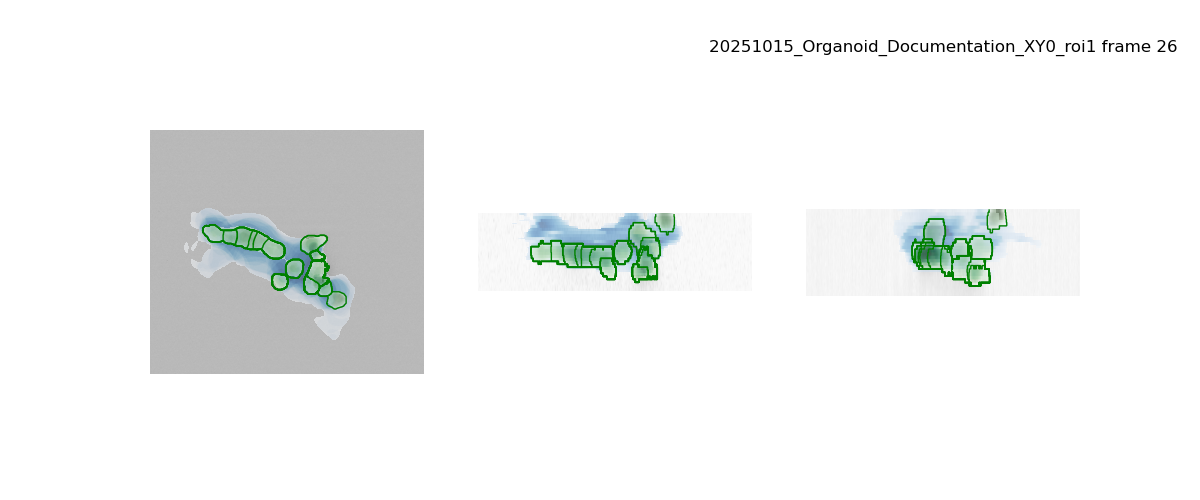

Ensure and compile all segmentations omitting any that failed

In [ ]:
modelList_flat=list(itertools.chain(*modelLists))
inds_missing=[]
for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    try:
        with h5py.File(h5filename,'r+') as f:
            fmsk=f['/images/img_70/fmsk']
            print(fmsk[...].shape)
            
            cpath=f['/metadata/cellpose_modelpath'][...]
            print(cpath)
            
            ipath=f['/metadata/ilastik_modelpath'][...]
            print(ipath)
            
            if fmsk.shape[3]!=6:
                inds_missing.append(i)
    except:
            print(f'problem on {h5filename}')
            inds_missing.append(i)

print(np.array(modelList_flat)[inds_missing])

We now create a consensus surface segmentation using 'nframe_window' to average microenvironemental mask over that time frame.  
Here, nframe_window is set to 6 which corresponds to 2hr (6x 20min imaging time frame). 

In [ ]:
nframe_window = 6 

import time 

vizpath='/mnt/d/vaibhav/Documentation/20251020_Consensus_surfaceseg_organoid'  
pathexists = os.path.isdir(vizpath)     
if not pathexists:
    os.mkdir(vizpath)
    
for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    sctm=trajectory.Trajectory(h5filename=h5filename)
    sctm.get_image_shape()
    print(f'{sctm.nmaskchannels}')

    cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
    nuc_img_channel=np.where(sctm.channels==np.array(['CY5']).astype('S32'))[0][0]  #NOTE THE NUC CHANNEL HERE 
    rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
    erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
    primary_fmskchannel=np.where(sctm.fmask_channels==np.array(['primary']).astype('S32'))[0][0]
    cancer_fmskchannel=np.where(sctm.fmask_channels==np.array(['cancer']).astype('S32'))[0][0]
    nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
    mskchannel=cyto_msk_channel; sctm.mskchannel=mskchannel
    sctm.load_from_h5(f'/cell_data_m{sctm.mskchannel}/')
    fmsks=np.zeros((sctm.nz,sctm.nx,sctm.ny,sctm.nt)).astype(bool)
    fmsks_cancer=np.zeros((sctm.nz,sctm.nx,sctm.ny,sctm.nt)).astype(bool)
    fmsks_primary=np.zeros((sctm.nz,sctm.nx,sctm.ny,sctm.nt)).astype(bool)

    #Cancer Mask-----------------------------------------------------------------------------------------------------------------------------------------
    for iS in range(sctm.nt):
        fmsks[...,iS]=sctm.get_fmask_data(iS,channel=cancer_fmskchannel)
    for iS in range(sctm.nt):
        fmin=iS-nframe_window; fmax=iS+nframe_window
        if fmax>sctm.nt:
            fmax=sctm.nt
        if fmin<0:
            fmin=0
        indframes=np.arange(fmin,fmax).astype(int)
        print(f'Building cancer surface mask over frames {fmin}-{fmax}...')
        fcancer=np.median(fmsks[...,indframes],axis=3).astype(bool)
        fmsks_cancer[...,iS]=fcancer
        clear_output(wait=True)
        plt.imshow(np.ma.masked_where(np.logical_not(np.max(fcancer,axis=0)),np.sum(fcancer,axis=0)),cmap=plt.cm.Greens,alpha=.8)
        plt.axis('off')
        plt.show()
    fmsks=np.zeros((sctm.nz,sctm.nx,sctm.ny,sctm.nt)).astype(bool)

    #Primary Mask-----------------------------------------------------------------------------------------------------------------------------------------
    for iS in range(sctm.nt):
        fmsks[...,iS]=sctm.get_fmask_data(iS,channel=primary_fmskchannel) 
    for iS in range(sctm.nt):
        fmin=iS-nframe_window; fmax=iS+nframe_window
        if fmax>sctm.nt:
            fmax=sctm.nt
        if fmin<0:
            fmin=0
        indframes=np.arange(fmin,fmax).astype(int)
        print(f'Building primary surface mask over frames {fmin}-{fmax}...')
        fprimary=np.median(fmsks[...,indframes],axis=3).astype(bool)
        fmsks_primary[...,iS]=fprimary    
        clear_output(wait=True)
        plt.imshow(np.ma.masked_where(np.logical_not(np.max(fprimary,axis=0)),np.sum(fprimary,axis=0)),cmap=plt.cm.Blues,alpha=.8)
        plt.axis('off')
        plt.show()
    sctm.fmsks_cancer=fmsks_cancer
    sctm.fmsks_primary=fmsks_primary
    sctm.save_to_h5(f'/cell_data_m{sctm.mskchannel}/',['fmsks_cancer','fmsks_primary'])
    
    for iS in range(sctm.nt):
        clear_output(wait=True)
        fmsk_primary=fmsks_primary[...,iS]
        fmsk_cancer=fmsks_cancer[...,iS]
        plt.imshow(np.ma.masked_where(np.logical_not(np.max(fmsk_primary,axis=0)),np.sum(fmsk_primary,axis=0)),cmap=plt.cm.Blues,alpha=.8)
        plt.imshow(np.ma.masked_where(np.logical_not(np.max(fmsk_cancer,axis=0)),np.sum(fmsk_cancer,axis=0)),cmap=plt.cm.Greens,alpha=.8)
        plt.axis('off')
        plt.title(f'{sctm.figid.decode()} f{iS}')
        plt.savefig(f'{vizpath}/{sctm.figid.decode()}_consensus_surf_f{iS:04d}.png')
        plt.show()

Save the consensus masks to the corresponding h5 files.

In [ ]:
fmask_channels=['foreground','nuc','primary','cancer','consensus_primary','consensus_cancer']

for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    sctm=trajectory.Trajectory(h5filename=h5filename)
    sctm.get_image_shape()
    
    cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
    nuc_img_channel=np.where(sctm.channels==np.array(['CY5']).astype('S32'))[0][0] #NOTE THE NUC CHANNEL HERE 
    rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
    erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
    nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
    mskchannel=cyto_msk_channel; sctm.mskchannel=mskchannel
    sctm.load_from_h5(f'/cell_data_m{sctm.mskchannel}/')
    plt.figure()
    for iS in range(0,sctm.nt):
        fstr=f'/images/img_{iS}/fmsk'
        with h5py.File(h5filename,'r+') as h:
            fmsk_df=h[fstr]
            print(f'{fstr} shape {fmsk_df[...].shape}')
            fmsks=fmsk_df[...]  
            if fmsks.shape[3]!=6:
                fmsks_set=np.concatenate((fmsks[...,0:4],sctm.fmsks_primary[...,iS,np.newaxis],sctm.fmsks_cancer[...,iS,np.newaxis]),axis=3)
                del h[fstr]
                h[fstr]=fmsks_set
        if False: 
            msk=sctm.get_mask_data(iS)
            plt.imshow(np.ma.masked_where(np.logical_not(np.max(sctm.fmsks_primary[...,iS],axis=0)),np.sum(sctm.fmsks_primary[...,iS],axis=0)),cmap=plt.cm.Blues,alpha=.5)
            plt.imshow(np.ma.masked_where(np.logical_not(np.max(sctm.fmsks_cancer[...,iS],axis=0)),np.sum(sctm.fmsks_cancer[...,iS],axis=0)),cmap=plt.cm.Greens,alpha=.5)
            plt.contour(np.max(msk[...,0],axis=0),levels=np.unique(np.max(msk[...,0],axis=0)),colors='green')
            plt.axis('off')
    sctm.fmask_channels=fmask_channels
    sctm.save_to_h5('/metadata/',['fmask_channels'],overwrite=True)


## Section 7: Featurize and Tracking

**Note: To featurize the contacts made and signaling characteristics, we need to go back to celltraj_env environment.**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/wsltools/programs/celltraj/celltraj')
import trajectory
import imageprep as imprep
import utilities
import features
import model
import h5py
import pickle
import os
import subprocess
import time
#import bootstrap
import umap
import pyemma.coordinates as coor
import scipy
import csaps
import skimage
from IPython.display import clear_output
import os
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
np.float=np.dtype(float)
np.int=int
import msmtools
import pandas
import itertools
import ray
import importlib
import convenience_features as cf
importlib.reload(cf)


Re-initialize the models and print a list of the models that need to be featurized.

In [ ]:
modelLists = [None] * 1
inds_imagingSet = []

# you only have one dataset, so index is always 0
modelLists[0] = imprep.list_images(f'{datapath}/{modelName}_XY*_roi*.h5')
inds_dataset = [0] * len(modelLists[0])
inds_imagingSet.append(inds_dataset)

inds_imagingSet = list(itertools.chain(*inds_imagingSet))

for ilist in range(len(modelLists)):
    print(f'movies: {modelLists[ilist]}')

In [ ]:
modelList_flat=list(itertools.chain(*modelLists))

inds_missing=[]
for i in range(len(modelList_flat)): 
    h5filename=modelList_flat[i]
    try:
        with h5py.File(h5filename,'r+') as f:
            fmsk=f['/images/img_70/fmsk']
            print(fmsk[...].shape)
            cpath=f['/metadata/cellpose_modelpath'][...]
            print(cpath)
            ipath=f['/metadata/ilastik_modelpath'][...]
            print(ipath)
            
            if fmsk.shape[3]!=6:
                inds_missing.append(i)
    except:
            print(f'problem on {h5filename}')
            inds_missing.append(i)

print(np.array(modelList_flat)[inds_missing])

In [ ]:
#@ray.remote(num_cpus=3)
def get_cellfeatures_distributed(h5filename):
    try: 
        output_message=f'featurizing {h5filename}...'
    
    ############################################ Load trajectory object from h5 file ################################################   
        sctm=trajectory.Trajectory(h5filename=h5filename)
        sctm.get_image_shape()
        print(f'{sctm.nmaskchannels}')
    
        
    ############################################ Describe channels and initialize ################################################       
        cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
        nuc_img_channel=np.where(sctm.channels==np.array(['CY5']).astype('S32'))[0][0] #NOTE THE NUC CHANNEL HERE 
        rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
        erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
        
        foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
        nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
        mskchannel=cyto_msk_channel; 
        sctm.mskchannel=mskchannel
    
    ############################################ Tracking and motility feature extraction ################################################       
        sctm.get_frames()
        sctm.get_cell_index(verbose=True,save_h5=True,overwrite=True)
        ntrans=[1,1,1]
        maxt=[0.,0.,0.]
       
        tf_matrix_set=sctm.get_stack_trans(mskchannel=sctm.mskchannel,
                                           ntrans=ntrans,
                                           maxt=maxt,
                                           dist_function=utilities.get_pairwise_distance_sum,
                                           save_h5=True,overwrite=True,do_global=False) 
        clear_output(wait=True)
        
        # Extract per-frame cell centroids
        x=sctm.get_cell_positions(mskchannel=sctm.mskchannel,save_h5=True,overwrite=True)
        clear_output(wait=True)
        
        # Compute padding needed for global image registration
        tf_matrix_set_pad,pad_dims=imprep.get_registration_expansions(sctm.tf_matrix_set,sctm.nz,sctm.nx,sctm.ny)
        sctm.pad_dims=np.array(pad_dims)
        sctm.save_to_h5(f'/cell_data_m{mskchannel}/',['pad_dims'])
        clear_output(wait=True)
        
        # Compute optimal transport-based cell lineage using OT cost
        ot_costs,linSet=sctm.get_lineage_min_otcost(distcut=0.5*sctm.cellpose_diam,
                                                    return_cost=True,
                                                    ot_cost_cut=np.inf,
                                                    border_resolution=1.33,
                                                    visual=False,save_h5=True,overwrite=True)
        
        output_message=f'{output_message} tracked...'
        clear_output(wait=True)
    
    ############################################ Signaling features ################################################       
        # ERK Cross-correlation calculation
        corrc_erk=sctm.get_cell_channel_crosscorr(mskchannel=cyto_msk_channel,
                                                  imgchannel1=nuc_img_channel,
                                                  imgchannel2=erk_img_channel,
                                                  save_h5=True,overwrite=True)
        corrc_erk=1.-corrc_erk
        clear_output(wait=True)
    
        #C/N Ratio of ERK
        cratio_erk=sctm.get_cell_compartment_ratio(imgchannel=erk_img_channel,
                                                   mskchannel1=cyto_msk_channel,
                                                   mskchannel2=None,
                                                   fmask_channel=nuc_fmskchannel,
                                                   make_disjoint=True,
                                                   remove_background_perframe=True,
                                                   inverse_ratio=False,
                                                   save_h5=True,overwrite=True)
        clear_output(wait=True)
       
        output_message=f'{output_message} signaling features...'
        
        sctm.get_cellboundary_library(surface_fmask_channels=[4,5],border_resolution=1.0,visual=True,save_h5=True,overwrite=True) #do this later on its own, after saving surface masks as medians over time windows
        mm_properties,property_names=sctm.get_multipole_boundarylibrary_properties(indcells=None,cell_states=[1],cell_state_labels=[None,'rep cell'],nn_states=[1,3,4],nn_state_labels=[None,'rep cell',None,'primary','matrix'],include_dx_prevs=True,include_dx_nexts=True,include_curvatures=True,include_vdists=False,include_shape=True,order=order,save_h5=True,overwrite=True)
        output_message=f'{output_message} added MVE boundary features...'
    except Exception as e:
        print(e)

In [ ]:
ray.init(num_cpus=9)

In [ ]:
results = [get_cellfeatures_distributed(h5filename) for h5filename in np.array(modelList_flat)]

In [ ]:
outputs=[]
for i in range(len(modelList_flat)): 

############################################ Load trajectory object from h5 file ################################################   
    h5filename=modelList_flat[i]
    sctm=trajectory.Trajectory(h5filename=h5filename)
    cyto_msk_channel=np.where(sctm.mask_channels==np.array(['cyto']).astype('S32'))[0][0]
    nuc_img_channel=np.where(sctm.channels==np.array(['CY5']).astype('S32'))[0][0]  #NOTE THE NUC CHANNEL HERE 
    rep_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    bf_img_channel=np.where(sctm.channels==np.array(['BF']).astype('S32'))[0][0]
    erk_img_channel=np.where(sctm.channels==np.array(['YFP']).astype('S32'))[0][0]
    foreground_fmskchannel=np.where(sctm.fmask_channels==np.array(['foreground']).astype('S32'))[0][0]
    nuc_fmskchannel=np.where(sctm.fmask_channels==np.array(['nuc']).astype('S32'))[0][0]
    mskchannel=cyto_msk_channel; 
    sctm.mskchannel=mskchannel
    status=sctm.load_from_h5(f'/cell_data_m{mskchannel}/')
    sctm.get_frames()
    
    # Count tracked cells by summing sizes of lineage sets per frame
    ntracked=0
    for iS in range(sctm.nt):
        ntracked=ntracked+sctm.linSet[iS].size
    
    output_str= f'count: {sctm.ncells_total}, tracked: {ntracked}'
    print(output_str)
    outputs.append(output_str)